In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import linear_model

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras import regularizers
from keras.optimizers import SGD


import matplotlib.pyplot as plt
import matplotlib
from matplotlib.legend_handler import HandlerLine2D
from matplotlib.colors import ListedColormap

import csv



matplotlib.rcParams['figure.figsize'] = (6.0, 6.0) # pour avoir des figures de même taille



def plot_histories(eta, epochs, cost_history, accuracy_history):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_ylabel(r'$J(\theta)$')
    ax.set_xlabel('Epochs')
    ax.set_title(r"$\eta$ :{}".format(eta))
    line1, = ax.plot(range(epochs), cost_history, label='Cost')
    line2, = ax.plot(range(epochs), accuracy_history, label='Accuracy')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})


def plot_decision_boundary(func, X, y):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)

    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    fig, ax = plt.subplots()
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)

    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)
    plt.title("Decision Boundary")

#fonctions utiles
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x)*(1.0 - sigmoid(x))

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1 - x ** 2

def relu(x):
    return np.maximum(0,x)

def relu_prime(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def leakyrelu(x):
    return np.maximum(0.01,x)

def leakyrelu_prime(x):
    x[x<=0] = 0.01
    x[x>0] = 1
    return x

def softmax(x):
    expx = np.exp(x - np.max(x))
    return expx / expx.sum(axis=0, keepdims=True)

Using TensorFlow backend.


In [2]:
class Layer:
    def __init__(self, output, *args, **kwargs):

        self.output = output  # Number of neurons at  layer i (current layer)
        self.input = kwargs.get("input", None)  # Number of neurons at layer i-1
        self.activ_function_curr = kwargs.get("activation", None)  # Activation function for the layer
        self.parameters = {}
        self.derivatives = {}
        self.activation_func = None
        if self.activ_function_curr == "relu":
            self.activation_func = relu
            self.backward_activation_func = relu_prime
        elif self.activ_function_curr == "sigmoid":
            self.activation_func = sigmoid
            self.backward_activation_func = sigmoid_prime
        elif self.activ_function_curr == "tanh":
            self.activation_func = tanh
            self.backward_activation_func = tanh_prime
        elif self.activ_function_curr == "leakyrelu":
            self.activation_func = leakyrelu
            self.backward_activation_func = leakyrelu_prime
        elif self.activ_function_curr == "softmax":
            self.activation_func = softmax
            self.backward_activation_func = softmax

    def initParams(self):
        # initialisation du dictionnaire de données parameters contenant W, A et Z pour un layer
        seed = 30
        np.random.seed(seed)
        self.parameters['W'] = np.random.randn(self.output, self.input) * np.sqrt(2 / self.input)
        self.parameters['b'] = np.random.randn(self.output, 1) * 0.1

    def setW(self, matW):
        self.parameters['W'] = np.copy(matW)

    def setA(self, matA):
        self.parameters['A'] = np.copy(matA)

    def setZ(self, matZ):
        self.parameters['Z'] = np.copy(matZ)

    def setB(self, matB):
        self.parameters['b'] = np.copy(matB)

    def setdW(self, matdW):
        self.parameters['dW'] = np.copy(matdW)

    def setdA(self, matdA):
        self.parameters['dA'] = np.copy(matdA)

    def setdZ(self, matdZ):
        self.parameters['dZ'] = np.copy(matdZ)

    def setdB(self, matdB):
        self.parameters['db'] = np.copy(matdB)

Content of the network:
Layer n°  0  => 
	Input  None 	Output 2
Layer n°  1  => 
	Input  2 	Output 3
	Activation Function <function relu at 0x0000022197E51678>
	W (3, 2) [[-1.26405266  1.52790535]
 [-0.97071094  0.47055962]
 [-0.10069672  0.30379318]]
	b (3, 1) [[-0.17259624]
 [ 0.15850954]
 [ 0.01342966]]
Layer n°  2  => 
	Input  3 	Output 1
	Activation Function <function sigmoid at 0x0000022197E51288>
	W (1, 3) [[-1.03209468  1.2475295  -0.79258216]]
	b (1, 1) [[0.04705596]]
Epoch : #1/200 - 600/600 - cost : 0.5145 - accuracy : 0.8986
Epoch : #2/200 - 600/600 - cost : 0.4710 - accuracy : 0.8865
Epoch : #3/200 - 600/600 - cost : 0.4596 - accuracy : 0.8931
Epoch : #4/200 - 600/600 - cost : 0.4501 - accuracy : 0.8920
Epoch : #5/200 - 600/600 - cost : 0.4430 - accuracy : 0.8805
Epoch : #6/200 - 600/600 - cost : 0.4361 - accuracy : 0.8925
Epoch : #7/200 - 600/600 - cost : 0.4284 - accuracy : 0.8953
Epoch : #8/200 - 600/600 - cost : 0.4210 - accuracy : 0.8920
Epoch : #9/200 - 600/600 - cos

Epoch : #160/200 - 600/600 - cost : 0.1359 - accuracy : 0.9666
Epoch : #161/200 - 600/600 - cost : 0.1368 - accuracy : 0.9688
Epoch : #162/200 - 600/600 - cost : 0.1401 - accuracy : 0.9649
Epoch : #163/200 - 600/600 - cost : 0.1365 - accuracy : 0.9622
Epoch : #164/200 - 600/600 - cost : 0.1356 - accuracy : 0.9704
Epoch : #165/200 - 600/600 - cost : 0.1309 - accuracy : 0.9660
Epoch : #166/200 - 600/600 - cost : 0.1276 - accuracy : 0.9704
Epoch : #167/200 - 600/600 - cost : 0.1355 - accuracy : 0.9737
Epoch : #168/200 - 600/600 - cost : 0.1488 - accuracy : 0.9688
Epoch : #169/200 - 600/600 - cost : 0.1362 - accuracy : 0.9715
Epoch : #170/200 - 600/600 - cost : 0.1236 - accuracy : 0.9688
Epoch : #171/200 - 600/600 - cost : 0.1283 - accuracy : 0.9682
Epoch : #172/200 - 600/600 - cost : 0.1273 - accuracy : 0.9677
Epoch : #173/200 - 600/600 - cost : 0.1311 - accuracy : 0.9753
Epoch : #174/200 - 600/600 - cost : 0.1289 - accuracy : 0.9704
Epoch : #175/200 - 600/600 - cost : 0.1247 - accuracy :

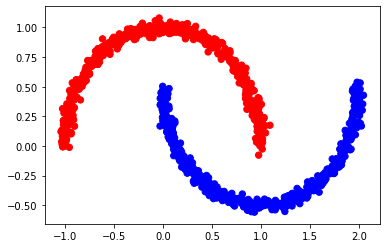

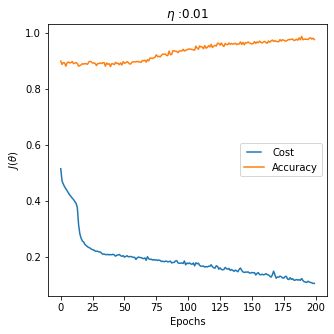

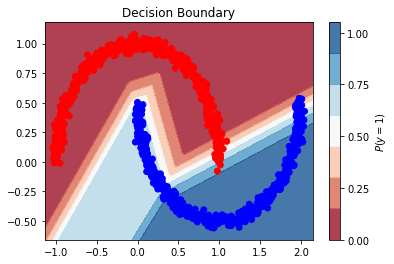

In [3]:
class MyNeuralNetwork:
    def __init__(self):
        self.nbLayers = 0
        self.layers = []

    def info(self):
        print("Content of the network:");
        j = 0;
        for i in range(len(self.layers)):
            print("Layer n° ", i, " => ")
            print("\tInput ", self.layers[i].input,
                  "\tOutput", self.layers[i].output)
            if (i != 0):
                print("\tActivation Function", self.layers[i].activation_func)
                print("\tW", self.layers[i].parameters['W'].shape, self.layers[i].parameters['W'])
                print("\tb", self.layers[i].parameters['b'].shape, self.layers[i].parameters['b'])

    def addLayer(self, layer):
        self.nbLayers += 1;
        if (self.nbLayers == 1):
            # this is the first layer so adding a layer 0
            layerZero = Layer(layer.input)
            self.layers.append(layerZero)

        self.layers.append(layer)
        self.layers[self.nbLayers].input = self.layers[self.nbLayers - 1].output
        self.layers[self.nbLayers].output = self.layers[self.nbLayers].output
        layer.initParams()

    def set_parametersW_b(self, numlayer, matX, matb):
        self.layers[numlayer].parameters['W'] = np.copy(matX)
        self.layers[numlayer].parameters['b'] = np.copy(matb)

    def forward_propagation(self, X):
        # Init predictive variables for the input layer
        self.layers[0].setA(X)

        # Propagation for all the layers
        for l in range(1, self.nbLayers + 1):
            # Compute Z
            self.layers[l].setZ(np.dot(self.layers[l].parameters['W'],
                                       self.layers[l - 1].parameters['A']) + self.layers[l].parameters['b'])
            # Applying the activation function of the layer to Z
            self.layers[l].setA(self.layers[l].activation_func(self.layers[l].parameters['Z']))

    def cost_function(self, y):
        return (-(y * np.log(self.layers[self.nbLayers].parameters['A'] + 1e-8) + (1 - y) * np.log(
            1 - self.layers[self.nbLayers].parameters['A'] + 1e-8))).mean()

    def backward_propagation(self, y):
        # calcul de dZ dW et db pour le dernier layer
        self.layers[self.nbLayers].derivatives['dZ'] = self.layers[self.nbLayers].parameters['A'] - y
        self.layers[self.nbLayers].derivatives['dW'] = np.dot(self.layers[self.nbLayers].derivatives['dZ'],
                                                              np.transpose(
                                                                  self.layers[self.nbLayers - 1].parameters['A']))
        m = self.layers[self.nbLayers].parameters['A'].shape[1]  # égal au nombre de colonnes de A
        self.layers[self.nbLayers].derivatives['db'] = np.sum(self.layers[self.nbLayers].derivatives['dZ'],
                                                              axis=1, keepdims=True) / m

        # calcul de dZ dW db pour les autres layers
        for l in range(self.nbLayers - 1, 0, -1):
            self.layers[l].derivatives['dZ'] = np.dot(np.transpose(self.layers[l + 1].parameters['W']),
                                                      self.layers[l + 1].derivatives['dZ']) * self.layers[
                                                   l].backward_activation_func(self.layers[l].parameters["Z"])

            self.layers[l].derivatives["dW"] = np.dot(self.layers[l].derivatives['dZ'],
                                                      np.transpose(self.layers[l - 1].parameters['A']))

            m = self.layers[l - 1].parameters['A'].shape[1]  # égal au nombre de colonnes de A
            self.layers[l].derivatives['db'] = np.sum(self.layers[l].derivatives['dZ'],
                                                      axis=1, keepdims=True) / m

    def update_parameters(self, eta):
        for l in range(1, self.nbLayers + 1):
            self.layers[l].parameters['W'] -= eta * self.layers[l].derivatives['dW']
            self.layers[l].parameters["b"] -= eta * self.layers[l].derivatives["db"]

    def convert_prob_into_class(self, probs):
        probs = np.copy(probs)  # pour ne pas perdre probs, i.e. y_hat
        probs[probs > 0.5] = 1
        probs[probs <= 0.5] = 0
        return probs

    def plot_W_b_epoch(self, epoch, parameter_history):
        mat = []
        max_size_layer = 0
        for l in range(1, self.nbLayers + 1):
            value = parameter_history[epoch]['W' + str(l)]
            if (parameter_history[epoch]['W' + str(l)].shape[1] > max_size_layer):
                max_size_layer = parameter_history[epoch]['W' + str(l)].shape[1]
            mat.append(value)
        figure = plt.figure(figsize=((self.nbLayers + 1) * 3, int(max_size_layer / 2)))
        for nb_w in range(len(mat)):
            plt.subplot(1, len(mat), nb_w + 1)
            plt.matshow(mat[nb_w], cmap=plt.cm.gist_rainbow, fignum=False, aspect='auto')
            plt.colorbar()
        thelegend = "Epoch " + str(epoch)
        plt.title(thelegend)

    def accuracy(self, y_hat, y):
        if self.layers[self.nbLayers].activation_func == softmax:
            # si la fonction est softmax, les valeurs sont sur différentes dimensions
            # il faut utiliser argmax avec axis=0 pour avoir un vecteur qui indique
            # où est la valeur maximale à la fois pour y_hat et pour y
            # comme cela il suffit de comparer les deux vecteurs qui indiquent
            # dans quelle ligne se trouve le max
            y_hat_encoded = np.copy(y_hat)
            y_hat_encoded = np.argmax(y_hat_encoded, axis=0)
            y_encoded = np.copy(y)
            y_encoded = np.argmax(y_encoded, axis=0)
            return (y_hat_encoded == y_encoded).mean()
        # la dernière fonction d'activation n'est pas softmax.
        # par exemple sigmoid pour une classification binaire
        # il suffit de convertir la probabilité du résultat en classe
        y_hat_ = self.convert_prob_into_class(y_hat)
        return (y_hat_ == y).all(axis=0).mean()
    
    def accuracy2(self, y_hat, y):
        if self.layers[self.nbLayers].activation_func == softmax:
            # si la fonction est softmax, les valeurs sont sur différentes dimensions
            # il faut utiliser argmax avec axis=0 pour avoir un vecteur qui indique
            # où est la valeur maximale à la fois pour y_hat et pour y
            # comme cela il suffit de comparer les deux vecteurs qui indiquent
            # dans quelle ligne se trouve le max
            y_hat_encoded = np.copy(y_hat)
            y_hat_encoded = np.argmax(y_hat_encoded, axis=0)
            y_encoded = np.copy(y)
            y_encoded = np.argmax(y_encoded, axis=0)
            return (y_hat_encoded == y_encoded).mean()
        # la dernière fonction d'activation n'est pas softmax.
        # par exemple sigmoid pour une classification binaire
        # il suffit de convertir la probabilité du résultat en classe
        y_hat_ = self.convert_prob_into_class(y_hat)
        
        val=0
        for i in range (len(y_hat_)):
            if (y_hat_[i]==y[i]):
                val+=1
        return val/len(y_hat_)        
        return (y_hat_ == y).all(axis=0).mean()
    
    def predict(self, x):
        self.forward_propagation(x)
        return self.layers[self.nbLayers].parameters['A']
    
    def predict_patterns(self, x):
        self.forward_propagation(x)
        tab = []
        for i in self.layers:
            tab.append(i.parameters['A'])
        return tab
        
    def next_batch(self, X, y, batchsize):
        # pour avoir X de la forme : 2 colonnes, m lignes (examples) et également y
        # cela permet de trier les 2 tableaux avec un indices de permutation
        X = np.transpose(X)
        y = np.transpose(y)

        m = len(y)
        # permutation aléatoire de X et y pour faire des batchs avec des valeurs au hasard
        indices = np.random.permutation(m)
        X = X[indices]
        y = y[indices]
        for i in np.arange(0, X.shape[0], batchsize):
            # creation des batchs de taille batchsize
            yield (X[i:i + batchsize], y[i:i + batchsize])

    def fit(self, X, y, *args, **kwargs):
        epochs = kwargs.get("epochs", 20)
        verbose = kwargs.get("verbose", False)
        eta = kwargs.get("eta", 0.01)
        batchsize = kwargs.get("batchsize", 32)
        # def fit(self, X, y, epochs, eta = 0.01,batchsize=64) :
        # sauvegarde historique coût et accuracy pour affichage
        cost_history = []
        accuracy_history = []
        parameter_history = []
        for i in range(epochs):
            i += 1
            # sauvegarde des coûts et accuracy par mini-batch
            cost_batch = []
            accuracy_batch = []
            # Descente de gradient par mini-batch
            for (batchX, batchy) in self.next_batch(X, y, batchsize):
                # Extraction et traitement d'un batch à la fois

                # mise en place des données au bon format
                batchX = np.transpose(batchX)
                if self.layers[self.nbLayers].activation_func == softmax:
                    # la classification n'est pas binaire, y a utilisé one-hot-encoder
                    # le batchy doit donc être transposé et le résultat doit
                    # être sous la forme d'une matrice de taille batchy.shape[1]

                    batchy = np.transpose(batchy.reshape((batchy.shape[0], batchy.shape[1])))
                else:
                    # il s'agit d'une classification binaire donc shape[1] n'existe
                    # pas
                    batchy = np.transpose(batchy.reshape((batchy.shape[0], 1)))
                # batchy=np.transpose(batchy.reshape((batchy.shape[0], 1)))
                self.forward_propagation(batchX)
                self.backward_propagation(batchy)
                self.update_parameters(eta)

                # sauvegarde pour affichage
                current_cost = self.cost_function(batchy)
                cost_batch.append(current_cost)
                y_hat = self.predict(batchX)
                current_accuracy = self.accuracy(y_hat, batchy)
                accuracy_batch.append(current_accuracy)

            # SaveStats on W, B as well as values for A,Z, W, b
            save_values = {}
            save_values["epoch"] = i
            for l in range(1, self.nbLayers + 1):
                save_values["layer" + str(l)] = l
                save_values["Wmean" + str(l)] = np.mean(self.layers[self.nbLayers].parameters['W'])
                save_values["Wmax" + str(l)] = np.amax(self.layers[self.nbLayers].parameters['W'])
                save_values["Wmin" + str(l)] = np.amin(self.layers[self.nbLayers].parameters['W'])
                save_values["Wstd" + str(l)] = np.std(self.layers[self.nbLayers].parameters['W'])
                save_values["bmean" + str(l)] = np.mean(self.layers[self.nbLayers].parameters['b'])
                save_values["bmax" + str(l)] = np.amax(self.layers[self.nbLayers].parameters['b'])
                save_values["bmin" + str(l)] = np.amin(self.layers[self.nbLayers].parameters['b'])
                save_values["bstd" + str(l)] = np.std(self.layers[self.nbLayers].parameters['b'])
                # be careful A,Z,W and b must be copied otherwise it is a referencee
                save_values['A' + str(l)] = np.copy(self.layers[self.nbLayers].parameters['A'])
                save_values['Z' + str(l)] = np.copy(self.layers[self.nbLayers].parameters['Z'])
                save_values['W' + str(l)] = np.copy(self.layers[self.nbLayers].parameters['W'])
                save_values['b' + str(l)] = np.copy(self.layers[self.nbLayers].parameters['b'])

            parameter_history.append(save_values)
            # sauvegarde de la valeur moyenne des coûts et de l'accuracy du batch pour affichage
            current_cost = np.average(cost_batch)
            cost_history.append(current_cost)
            current_accuracy = np.average(accuracy_batch)
            accuracy_history.append(current_accuracy)

            if (verbose == True):
                print("Epoch : #%s/%s - %s/%s - cost : %.4f - accuracy : %.4f" % (
                i, epochs, X.shape[1], X.shape[1], float(current_cost), current_accuracy))

        return self.layers, cost_history, accuracy_history, parameter_history
    
    
X,y = make_moons(n_samples = 1000, noise=0.03, random_state=0)
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=cm_bright)#cmap=plt.cm.PiYG)

#création d'un jeu d'apprentissage et de test
validation_size=0.6 #40% du jeu de données pour le test
testsize= 1-validation_size
seed=30
# séparation jeu d'apprentissage et jeu de test
X_train,X_test,y_train,y_test=train_test_split(X,
                                               y,
                                               train_size=validation_size,
                                               random_state=seed,
                                               test_size=testsize)

#transformation des données pour être au bon format
# X_train est de la forme :x 2 colonnes, m lignes (eamples)
# y_train est de la forme : m colonnes, 1 ligne

# La transposée de X_train est de la forme : m colonnes (exemples), 2 lignes
X_train=np.transpose(X_train)

# y_train est forcé pour être un tableau à 1 ligne contenant m colonnes
y_train=np.transpose(y_train.reshape((y_train.shape[0], 1)))

# mêmes traitements pour le jeu de test
X_test=np.transpose(X_test)
y_test=np.transpose(y_test.reshape((y_test.shape[0], 1)))

network = MyNeuralNetwork()
network.addLayer(Layer(3,input=2,activation="relu"))
network.addLayer(Layer(1,activation="sigmoid"))

network.info()

epochs = 200
eta = 0.01
batchsize=32

#Entraînement du classifieur
layers,cost_history,accuracy_history,parameter_history=network.fit(X_train, y_train, verbose=True, epochs=epochs)

# Affichage des historiques
plot_histories(eta,epochs,cost_history,accuracy_history)
# Affichage de la frontière de décision
plot_decision_boundary(lambda x: network.predict(np.transpose(x)), X, y)
#plot_decision_boundary(lambda x: clf.predict(np.transpose(x)), X, y)

y_pred=network.predict(X_test)
accuracy_test = network.accuracy(y_pred, y_test)

print("Accuracy test: %.3f"%accuracy_test)

100
100
y_pred_classe :  [0.002465735652601141, 0.002439603620974722, 0.002308312923097087, 0.0022395308928370395, 0.0020565051176389976, 0.001990070789952471, 0.0019846312340487888, 0.0019365146364452189, 0.0016463850292264106, 0.0015751346313007419, 0.0015268491304839388, 0.0015021901629658108, 0.0014877933509398111, 0.001458831267110201, 0.0014169619592001058, 0.0013529733531088039, 0.0013304214499319468, 0.0012352181036577286, 0.0012197713819371847, 0.001189937247200428, 0.001175173178541638, 0.0011710899203095538, 0.0011214181021709283, 0.0010980704997148524, 0.0010949042369069093, 0.0010680578682827737, 0.0010670492747323452, 0.001064555834474115, 0.001060286494499728, 0.001053760051814874, 0.0010126305135508833, 0.0009750028975927469, 0.0009714106614097147, 0.0009710812213093739, 0.0009440371626537307, 0.0009311636390075031, 0.0009298779851046929, 0.0009212279771570369, 0.0008668989644152945, 0.0008501982784444691, 0.0008160641901406496, 0.0007882639811136976, 0.0007851281382990

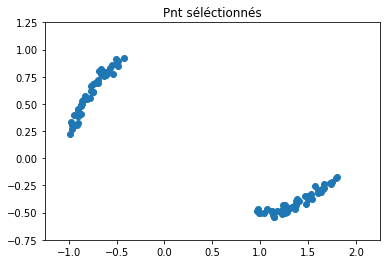

In [4]:
class Point :
    activation_val = 0
    x = 0
    y = 0
    
    def __init__(self,av):
        self.activation_val = av
        self.x = 0
        self.y = 0
    
    def __str__(self):
        return str(self.__dict__)
    
def layers_to_csv(filename,X,y,y_preds):
    f = open(filename,'w')

    for i in range(len(X[0])):
        string = str(y[i])+','
        for nb_layers in range(1,2):
            string+="<L>,"
            for j in range(len(y_preds[nb_layers])): 
                string+=str(y_preds[nb_layers][j][i])+','
            string+="</L>,"
        string=string[0:-1]
        string+='\n'
        f.write(string)

    f.close()

def setHeader(filename):
    with open('layers_to_csv_2_3_1_.csv',newline='') as f:
        r = csv.reader(f)
        data = [line for line in r]
    with open('layers_to_csv_2_3_1_.csv','w',newline='') as f:
        w = csv.writer(f)
        w.writerow(['Classe','','N1','N2','N3',''])
        w.writerows(data)
        
def tabPointSelect(X_test_propre,y_test_classe):
    pnts_X = []
    pnts_Y = []
    for i in range(len(X_test_propre[0])):
        pnts_X.append(X_test_propre[0][i])
        pnts_Y.append(X_test_propre[1][i])
    
    plt.show()  
    plt.xlim(-1.25, 2.25)
    plt.ylim(-0.75, 1.25)
    plt.scatter(pnts_X, pnts_Y)#cmap=plt.cm.PiYG)
    plt.title("Pnt séléctionnés")#cmap=plt.cm.PiYG)
    
    
    
tab_min = []
for val in range(50):   
    tab_min.append(Point(1))

tab_max = []
for val in range(50):   
    tab_max.append(Point(0))

for ind in range(len(y_pred[0])):
    tab_min = sorted(tab_min,key=lambda Point: Point.activation_val, reverse=True)
    tab_max = sorted(tab_max,key=lambda Point: Point.activation_val, reverse=False)
    
    if y_pred[0][ind] < tab_min[0].activation_val:
        tab_min[0].activation_val = y_pred[0][ind]
        tab_min[0].x = X_test[0][ind]
        tab_min[0].y = X_test[1][ind]
        
    if y_pred[0][ind] > tab_max[0].activation_val:
        tab_max[0].activation_val = y_pred[0][ind]
        tab_max[0].x = X_test[0][ind]
        tab_max[0].y = X_test[1][ind]
            
tab_min = sorted(tab_min,key=lambda Point: Point.activation_val, reverse=True)
tab_max = sorted(tab_max,key=lambda Point: Point.activation_val, reverse=False)

y_pred_classe = []
y_test_classe=[]
for var in tab_min:
    y_pred_classe.append(var.activation_val)
    y_test_classe.append(0)
    #print(var)

for var in tab_max:
    y_pred_classe.append(var.activation_val)
    y_test_classe.append(1)
    #print(var)

print (len(y_pred_classe))
print (len(y_test_classe))
print("y_pred_classe : ",y_pred_classe)
print("y_test_classe : ",y_test_classe)

#y_pred_classe[13]=0.0006               #POUR TESTER SI ON PEUT PASSER EN DESSOUS DU 1 DE ACCURACY
#y_pred_classe[13]=0.00060882639811136962 
#y_pred_classe[1]=0.99984656565654985558

"""print("y_pred_classe : ,y_pred_classe)
print("y_test_classe : ",y_test_classe)
print (len(y_pred_classe))
print (len(y_test_classe))"""
accuracy_test_classe = network.accuracy2(y_pred_classe, y_test_classe)
print("\nTest accuracy classes : %f"%accuracy_test_classe)

X_test_propre = []

X_test_X = []
X_test_Y = []

for obj in tab_min:
    X_test_X.append(obj.x)
    X_test_Y.append(obj.y)
                                            #A OPTI
for obj in tab_max:
    X_test_X.append(obj.x)
    X_test_Y.append(obj.y)
    
X_test_propre.append(X_test_X)    
X_test_propre.append(X_test_Y) 

#ICI X_test_propre CORRESPOND A NOS 20 VALEURS

#Prédiction avec les 20 valeurs
y_preds=network.predict_patterns(X_test_propre)
y_preds_classe = []
for i in y_pred_classe:
    y_preds_classe.append(round(i))
   
tabPointSelect(X_test_propre,y_test_classe)

In [5]:
layers_to_csv("layers_to_csv_2_3_1_tmp",X_test_propre,y_preds_classe,y_preds)

#os.remove ('layers_to_csv_2_3_1_.csv')
# tri du fichier
os.system ('sort layers_to_csv_2_3_1_tmp > layers_to_csv_2_3_1_.csv')
setHeader("layers_to_csv_2_3_1_.csv")
# effacer le fichier intermédiaire
#os.remove ('layers_to_csv_2_3_1_tmp')


Moyenne du résultat de la fonction d'activation pour chaque neurones sans prise en compte classes : 
N1    0.884409
N2    1.218933
N3    1.163511
dtype: float64

Médiane du résultat de la fonction d'activation pour chaque neurones sans prise en compte classes : 
N1    0.796601
N2    0.895696
N3    0.678950
dtype: float64

Moyenne Classe/Neurones : 
              N1        N2        N3
Classe                              
0.0     1.768817  0.000000  0.000000
1.0     0.000000  2.437866  2.327022

Médiane Classe/Neurones : 
              N1        N2        N3
Classe                              
0.0     1.783257  0.000000  0.000000
1.0     0.000000  2.450121  2.255123

Min Classe/Neurones : 
       Unnamed: 1        N1        N2      N3 Unnamed: 5
Classe                                                  
0.0           <L>  1.593202  0.000000  0.0000       </L>
1.0           <L>  0.000000  1.791392  1.3579       </L>

Max Classe/Neurones : 
       Unnamed: 1        N1        N2        N3 

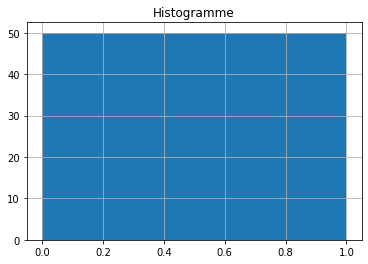

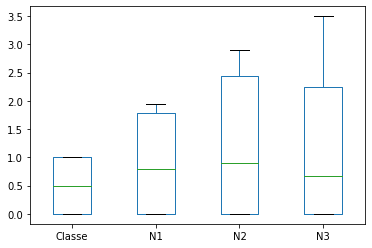

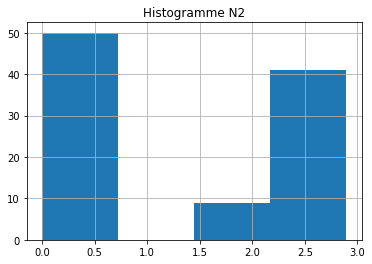

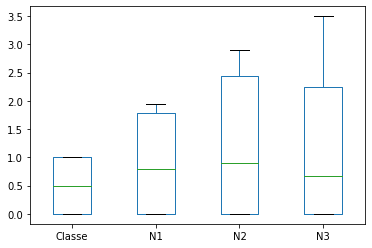

In [8]:
import pandas as pd


df = pd.read_csv (r'layers_to_csv_2_3_1_.csv')
print("\nMoyenne du résultat de la fonction d'activation pour chaque neurones sans prise en compte classes : ")
print(df.mean(axis = 0)[1:len(df)])   

print("\nMédiane du résultat de la fonction d'activation pour chaque neurones sans prise en compte classes : ")
print(df.median(axis = 0)[1:len(df)])   

print("\nMoyenne Classe/Neurones : ")
print(df.groupby('Classe').mean())

print("\nMédiane Classe/Neurones : ")
print(df.groupby('Classe').median())

print("\nMin Classe/Neurones : ")
print(df.groupby('Classe').min())

print("\nMax Classe/Neurones : ")
print(df.groupby('Classe').max())

data = pd.DataFrame({
    "Histogramme":df.iloc[:,0]
    })
hist = data.hist(bins=2)
df.plot.box()


dataN2 = pd.DataFrame({
        "Histogramme N2":df.iloc[:,3]
        })
hist = dataN2.hist(bins=4)
df.plot.box()


df["valQ"]=pd.qcut(df["N2"],2,labels=["0","1"])
df["valQ"].describe()
print("test :",df["valQ"])